## Using Yelp Open Dataset

##### Currently, users' opinions about a particular restaurant on Yelp are heavily influenced by only a few aspects displayed on the business's yelp page. Here are just a few:

1. Number of reviews on the restaurant
2. The overall rating of the restaurant (out of 5 stars)
3. Photos
4. The top listed reviews picked by Yelp
5. Popular dishes

Despite Yelp's attempt to give users an overview of what the restaurant is like, it is still a very cumbersome job for users to browser through all these information and make an informed decision which yields a positive experience for the user overall.


This project is an attempt to increase overall user experience by analyzing all of a restaurant's reviews and summarizing the main topics in a form of unigram adjectives clouds describing each of the main topics. 

In [1]:
import pandas as pd, numpy as np

In [2]:
yelp_df = pd.read_pickle('yelp_df_top_cities.pkl')

In [3]:
yelp_df.head()

,categories,city,name,state,text,Afghan,African,Senegalese,South African,American (New),...,Trophy Shops,Uniforms,Used Bookstore,Vape Shops,Vitamins & Supplements,Watches,Wholesale Stores,Wigs,yelp_all_top20,major_city
0,"Sushi Bars, Restaurants, Japanese",Charlotte,Musashi Japanese Restaurant,NC,"Husband was craving Chicken Teriyaki & gyoza, ...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,Taco Bell,AZ,"I mean it's Taco Bell, so it is what it is. Ho...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,"Restaurants, Italian",Las Vegas,Carluccio's Tivoli Gardens,NV,"We went there for dinner the other night, bein...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",Pittsburgh,Marathon Diner,PA,"Marathon Diner may not look fancy, but I had t...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,Maria's Mexican Restaurant & Bakery,NV,We found out about this gem from The Man's co-...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [93]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Extract the city and food category df combination

In [101]:
from sklearn.feature_extraction import text
my_stop_words = ['food', 'good', 'place']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [119]:
def food_city_df_count_vectorizer(food_type, city):
    
    # create df
    food_city_df = yelp_df[(yelp_df['city'] == city) & (yelp_df[food_type] == 1)]
    
    # create a list of all the reviews for each restaurant
    food_city_reviews = [review for review in food_city_df.text]
    
    # tokenize the whole corpus into bigrams and trigrams only with binary = False
    vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
    doc_word = vectorizer.fit_transform(food_city_reviews)
    print(f'There are {doc_word.shape[0]} restaurants and {doc_word.shape[1]} vocabulary')
    
    return doc_word, vectorizer

#### Latent Semantic Analysis

In [8]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
def LSA(doc_word, num_topics):
    lsa = TruncatedSVD(num_topics)
    doc_topic = lsa.fit_transform(doc_word)
    print(lsa.explained_variance_ratio_)
    print(f'Total variance explained by these topics is: {sum(lsa.explained_variance_ratio_)}')
    
    return lsa

In [9]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''
    INPUT: model, word-feature-name, # of top_words
    
    OUTPUT: List of word-features associated with each component
    with highest correlations in descending order
    '''
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
def create_topic_dict(model, feature_names, no_top_words, topic_names=None):
    '''
    INPUT: model, feature_names, # of top_words
    
    OUTPUT: a dictionary where keys are topics and values are the list of 
    words corresponding to that topic with the highest correlations
    '''
    
    # Create an empty dictionary by initializing all the topics
    topic_dict = {k:[] for k in range(len(model.components_))}
    
    # For each topic, append the word to the topic dictionary beginning with the highest correlation
    for ix, topic in enumerate(model.components_):
        for i in topic.argsort()[:-no_top_words - 1: -1]:
            topic_dict[ix].append(feature_names[i])
    
    return topic_dict

In [120]:
def create_word_list(list_of_words):
    
    '''
    INPUT: a list of unigrams, bigrams, trigrams
    OUTPUT: a list of unigrams from the list of words
    '''
    
    word_list = []
    
    for element in list_of_words:
        word_list.append(element)
#         for word in element.split():
#             word_list.append(word)
    
    return word_list

In [121]:
def create_word_cloud(word_list, width=480, height=480, max_words=10):
    
    '''
    INPUT: a list of words
    OUT: word cloud
    '''
    
    from wordcloud import WordCloud 
    import matplotlib.pyplot as plt

    # empty string is declare 
    text = ""

    # iterating through list of words
    for word in word_list : 

        text = text + " " + word

    wordcloud = WordCloud(width=width, height=height, max_words=max_words).generate(text) 
    return wordcloud

### Workflow

In [20]:
# create word_doc by tokenizing a list of all the reviews for a restaurant belonging to a city and food category

food_category = 'Sandwiches'
city = 'Las Vegas'

# returns a tuple of (word_doc, TfidF_tokenizer)
word_doc_tokenizer = food_city_df_Tfidf_tokenizer(food_category, city)

There are 741 restaurants and 6470107 vocabulary


In [21]:
# initialize LSA model and fit_transform the model using the tokenized vocabulary matrix from above

num_topics = 5

# (word_doc, TfidF_tokenizer)[0] = word_doc
word_doc = word_doc_tokenizer[0]

model_lsa = LSA(word_doc, num_topics)

[0.00140233 0.00170464 0.00169622 0.0014695  0.00140208]
Total variance explained by these topics is: 0.0076747740152398325


In [23]:
# print all the topics and their associated vocabulary from highest correlation

model = model_lsa

# (word_doc, TfidF_tokenizer)[1] = TfidF_tokenizer
feature_names = word_doc_tokenizer[1].get_feature_names()

display_topics(model, feature_names, 20)


Topic  0
customer service, really good, las vegas, staff friendly, food good, pretty good, don know, great service, great food, fast food, service great, food great, make sure, love place, good food, friendly staff, 10 minutes, super friendly, feel like, highly recommend

Topic  1
port subs, make sandwich, making sandwich, making sandwiches, like subway, customer service, store clean, sub shop, roast beef, sandwich shop, sandwich shops, subs location, foot long, great sandwich, favorite sandwich, worst subway, make sandwiches, meat cheese, order sandwich, wheat bread

Topic  2
pizza places, order pizza, good pizza, great pizza, best pizza, ordered pizza, pizza good, pizza ve, pizza hut, pizza great, pizza delicious, love pizza, large pizza, pizza place, pizza ordered, pizza wings, cheese pizza, pizza order, pizza delivery, pizza crust

Topic  3
tropical smoothie, make smoothie, tropical smoothie cafe, smoothie cafe, smoothie place, love tropical smoothie, love tropical, smoothie locat

In [34]:
# create a topic dictionary where the keys are the topics and values are the list of words 

topic_dict = create_topic_dict(model, feature_names, 200)

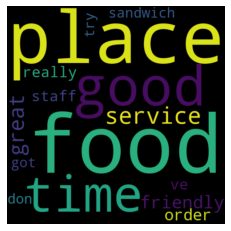

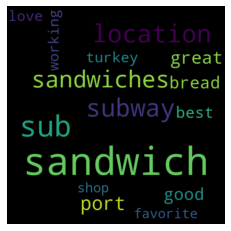

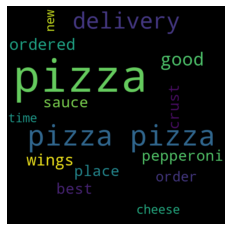

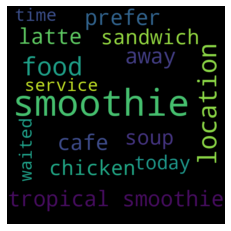

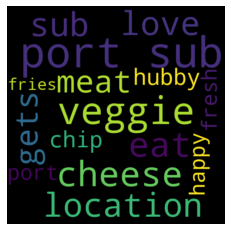

In [38]:
# create word list from topic dictionary then make a word cloud for each topic
plt.figure(figsize = (10,10))
subplot = 1

# k is the topic num, v is the vocabulary most similar to that topic space
for k,v in topic_dict.items():
    word_list = create_word_list(v)

    import collections
    # count the frequency of the word list
    counted_words = collections.Counter(word_list)

    wordcloud = create_word_cloud(word_list, width = wc_width, height = wc_height, max_words=max_words_wc)
    plt.subplot(2,3,subplot)
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 

    # create the title using the top two most frequency word for that topic
    plt.title(counted_words.most_common(2)[0][0].upper() + ' ' + counted_words.most_common(2)[1][0].upper(), size = 15)
    subplot +=1

plt.tight_layout()

In [ ]:
def top_modeling(city, food_category, 
                 num_topics = 4, num_vocabs = 200, 
                 max_words_wc = 20, wc_width = 600, wc_height = 600):

    # returns a tuple of (word_doc, TfidF_tokenizer)
    word_doc_tokenizer = food_city_df_count_vectorizer(food_category, city)
    
    # (word_doc, TfidF_tokenizer)[0] = word_doc
    word_doc = word_doc_tokenizer[0]

    # initialize LSA model and fit_transform the model using the tokenized vocabulary matrix from above
    model_lsa = LSA(word_doc, num_topics)
    
    # (word_doc, TfidF_tokenizer)[1] = TfidF_tokenizer[1] <- tokenizer
    feature_names = word_doc_tokenizer[1].get_feature_names()
    
    # create a topic dictionary where the keys are the topics and values are the list of words 
    topic_dict = create_topic_dict(model_lsa, feature_names, num_vocabs)
    
    # create word list from topic dictionary then make a word cloud for each topic
    plt.figure(figsize = (10,10))
    subplot = 1
    
    # k is the topic num, v is the vocabulary most similar to that topic space
    for k,v in topic_dict.items():
#         word_list = create_word_list(v)
        word_list = v
        
        import collections
        # count the frequency of the word list
        counted_words = collections.Counter(word_list)
        
        wordcloud = create_word_cloud(word_list, width = wc_width, height = wc_height, max_words=max_words_wc)
        plt.subplot(2,3,subplot)
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.margins(x=0, y=0) 
        
        # create the title using the top two most frequency word for that topic
#         plt.title(counted_words.most_common(2)[0][0].upper() + ' ' + counted_words.most_common(2)[1][0].upper())
        plt.title(counted_words.most_common(2)[0][0].upper())
        subplot += 1
        
    plt.tight_layout()

There are 398 restaurants and 7969719 vocabulary
[0.00207806 0.00298295 0.00271836 0.00265273 0.00259489 0.00258824]
Total variance explained by these topics is: 0.015615234007037229


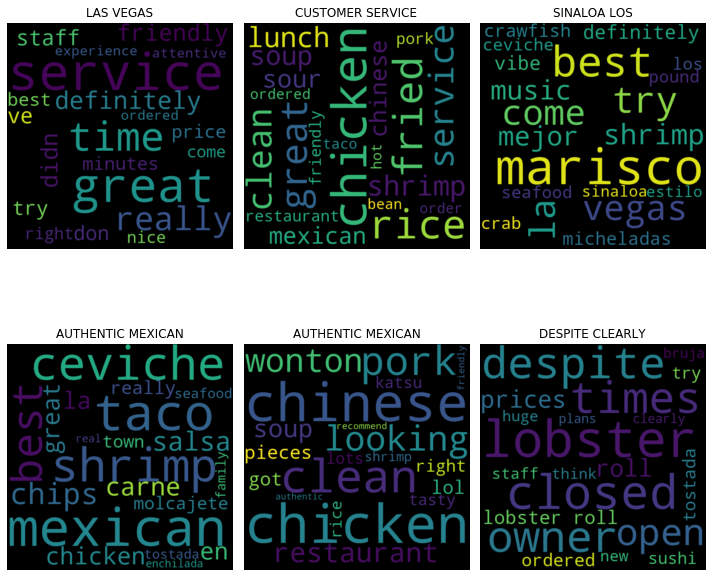

In [125]:
top_modeling('Las Vegas', 'Seafood', num_topics = 6)

There are 156 restaurants and 1312640 vocabulary
[0.00295554 0.00658559 0.00647387]
Total variance explained by these topics is: 0.016015000129844074


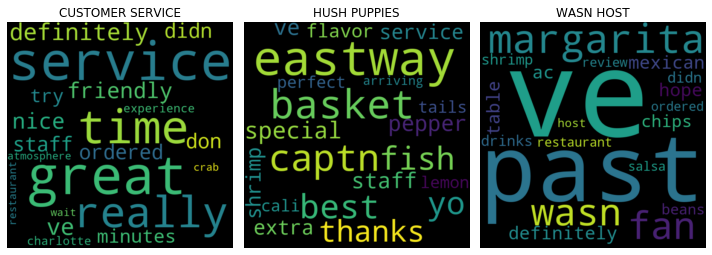

In [126]:
top_modeling('Charlotte', 'Seafood', num_topics = 3)

There are 100 restaurants and 1127701 vocabulary
[0.00349994 0.01034263 0.01022413]
Total variance explained by these topics is: 0.02406670720267867


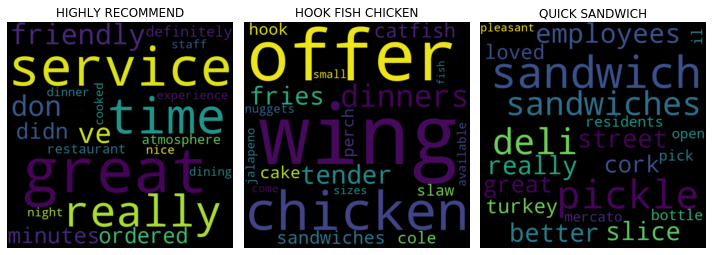

In [127]:
top_modeling('Pittsburgh', 'Seafood', num_topics = 3)

There are 170 restaurants and 2225985 vocabulary
[0.00302106 0.00612884 0.00594646 0.00598607 0.00597706 0.00595604]
Total variance explained by these topics is: 0.033015533602290946


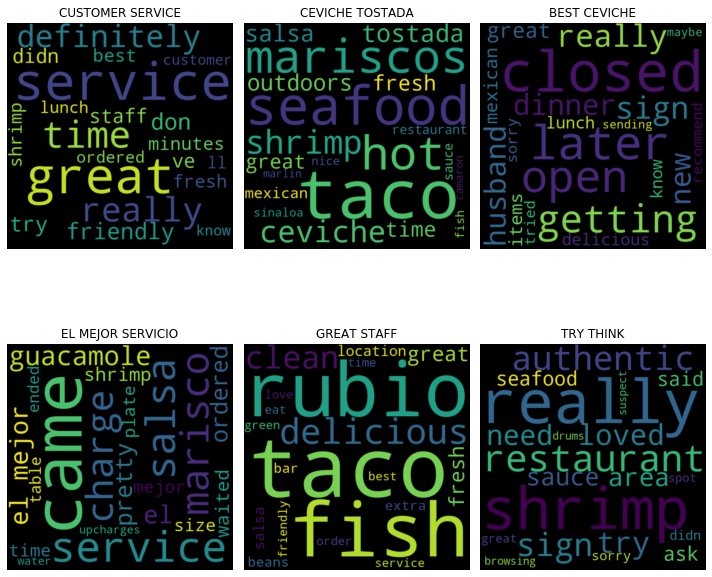

In [128]:
top_modeling('Phoenix', 'Seafood', num_topics = 6)